Необхідно порахувати результати A/A-тесту, перевіряючи метрику якості FPR (будемо перевіряти на конверсії в покупку). Відомо, що спліт-система зламана.

Потрібно перевірити твердження про поламку і знайти її причини, якщо спліт-система дійсно зламана.

1. Запустіть A/A-тест.

In [8]:
import pandas as pd

# дані
data_url = "https://raw.githubusercontent.com/Aranaur/aranaur.rbind.io/main/datasets/aa_test/aa_test.csv"
data = pd.read_csv(data_url, sep=";")

# перевірка кількості та унікальних значень
print(data.head())
print("Кількість спостережень:", data.shape[0])
print("Унікальні версії додатка:", data['version'].unique())

   Unnamed: 0                               uid  experimentVariant version  \
0           1  c4ca4238a0b923820dcc509a6f75849b                  1  v2.8.0   
1           2  c81e728d9d4c2f636f067f89cc14862c                  0  v2.9.0   
2           3  eccbc87e4b5ce2fe28308fd9f2a7baf3                  1  v2.9.0   
3           4  a87ff679a2f3e71d9181a67b7542122c                  1  v2.8.0   
4           5  e4da3b7fbbce2345d7772b0674a318d5                  1  v2.8.0   

   purchase  
0         0  
1         0  
2         0  
3         0  
4         0  
Кількість спостережень: 127018
Унікальні версії додатка: ['v2.8.0' 'v2.9.0' 'v3.7.4.0' 'v3.8.0.0']


2. Порахуйте FPR на рівні a = 0.05 (ставте підвибірки без повернення обсягом 1000). Ви побачите, що FPR > a! 
Нам потрібно навпаки — щоб було менше.

In [9]:
import numpy as np

def calculate_fpr(sample):    
    non_purchases = sample[sample['purchase'] == 0].shape[0]
    total_users = sample.shape[0]
    return non_purchases / total_users

n_samples = 1000
n_iterations = data.shape[0] // n_samples

fprs = []

for i in range(n_iterations):
    sample = data.sample(n_samples, replace=False, random_state=i)
    fpr = calculate_fpr(sample)
    fprs.append(fpr)

mean_fpr = np.mean(fprs)
print(f"Середній FPR: {mean_fpr:.4f}")

Середній FPR: 0.9612


Побудували функцію для підрахунку FPR (False Positive Rate)
Спочатку вона рахує кількість користувачів, які не зробили покупку, далі кількість всіх користувачів у вибірці і повертає FPR, тобто кількість "0" серед покупок / загальна кількість.

Далі визначаємо кількість підвибірок обсягом 1000 і виведемо середнє FPR та діапазон значень

Висновок: FPR — це частка користувачів, які не зробили покупку, серед загальної кількості користувачів. Наш результат FPR вказує на те, що більшість користувачів у підвибірці не зробили покупку. FPR перевищує 0.05 - це підтверджує гіпотезу, що спліт-система зламана, оскільки значення FPR має бути набагато меншим.

3. Знайдіть причини поламки спліт-системи, орієнтуючись на результати експерименту (підказка: знайдіть аномалію у версії додатка).

Розподіл версій додатка:
version
v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: count, dtype: int64


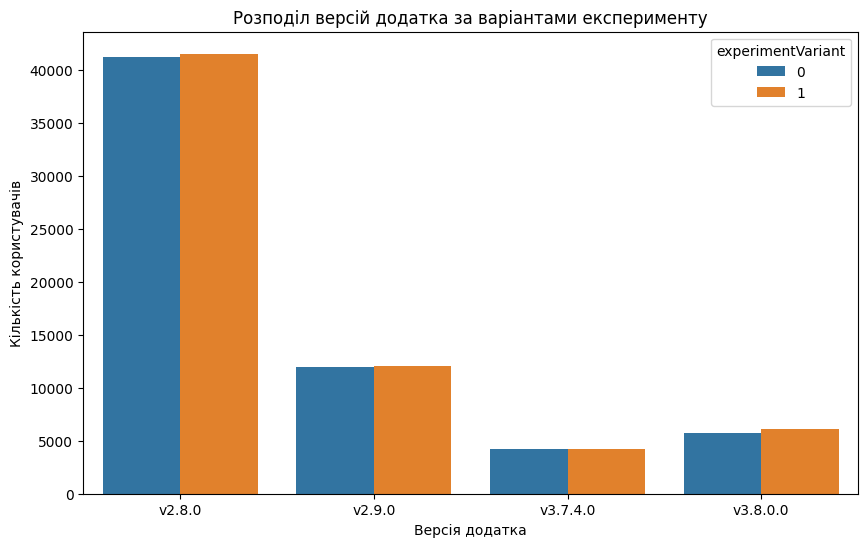


Контингентна таблиця версій додатка:
experimentVariant      0      1
version                        
v2.8.0             41283  41552
v2.9.0             11921  12033
v3.7.4.0            4204   4221
v3.8.0.0            5694   6110

Результати тесту хі-квадрат: p-value = 0.0124
Існує статистично значуща залежність між версією додатка і варіантом експерименту (p < 0.05).


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# аналіз розподілу версій додатка
version_distribution = data['version'].value_counts()
print("Розподіл версій додатка:")
print(version_distribution)

# граф
plt.figure(figsize=(10,6))
sns.countplot(x='version', hue='experimentVariant', data=data)
plt.title('Розподіл версій додатка за варіантами експерименту')
plt.xlabel('Версія додатка')
plt.ylabel('Кількість користувачів')
plt.show()

# контингентна таблиця для аналізу аномалій у версіях
contingency_table = pd.crosstab(data['version'], data['experimentVariant'])
print("\nКонтингентна таблиця версій додатка:")
print(contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table) # тест хі-квадрат для перевірки залежності між версією додатка та варіантами експерименту

print(f"\nРезультати тесту хі-квадрат: p-value = {p:.4f}")

if p < 0.05:
    print("Існує статистично значуща залежність між версією додатка і варіантом експерименту (p < 0.05).")
else:
    print("Немає статистично значущої залежності між версією додатка і варіантом експерименту (p >= 0.05).")


4. Напишіть висновки, які можна зробити на основі аналізу результатів A/A-тесту.

Висновки для завдання 4:
1) У другому завданні ми побачили, що показник FPR набагато перевищує допустимий рівень 0.05, що вказує на проблеми з розподілом груп або впливом певних чинників на результат.

2) У третьому завданні ми виявили аномалії у версіях додатка. Це свідчить про те, що розподіл користувачів по експериментальним варіантам залежить від версії додатка, що є порушенням правил A/A-тестування. 

3) Поломка спліт-системи підтверджена аналізом хі-квадрат, який вказав на велику залежність між версією додатка і варіантами експерименту. Це свідчить про те, що система потребує виправлення і результати A/A-тесту не можна вважати достовірними.